In [1]:
%load_ext autoreload
%autoreload 2

import dataclasses
import logging
import pathlib

import numpy as np
import pandas as pd
import sklearn.ensemble as ensemble
import sklearn.metrics
import sklearn.model_selection
import xarray as xr

import a6
import a6.datasets.coordinates as _coordinates
import a6.datasets.variables as _variables
import a6.utils as utils
import a6.plotting._colors as _colors

WORKER_ID = 4

utils.logging.create_logger(
    global_rank=WORKER_ID,
    local_rank=WORKER_ID,
    verbose=True,
)

logger = logging.getLogger("notebook")


turbine_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production"
)
preprocessed_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production-preprocessed-status-filter"
)
results_dir = pathlib.Path("/p/project/deepacf/emmerich1/data/forecast-errors-randomized-labels")

turbine_files = a6.utils.paths.list_files(
    turbine_data_dir, pattern="**/*.nc", recursive=True
)

turbine_error_files = a6.utils.paths.list_files(
    results_dir, pattern="*.nc", recursive=False
)
turbine_errors = [xr.open_dataset(path) for path in turbine_error_files]

plots = pathlib.Path("/p/project/deepacf/emmerich1/plots")

results = xr.open_dataset(
    "/p/project/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)
n_lswr_categories = 40
results_40 = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset(
    "/p/home/jusers/emmerich1/juwels/code/a6/src/tests/data/gwl.nc"
)
dcv2 = xr.open_dataset("/p/project/deepacf/emmerich1/data/dcv2-lswrs.nc")

lswrs = ["Default", gwl["GWL"], results_40["PCA"], results_40["kPCA"], dcv2["DCv2"], "Random"]

coordinates: _coordinates.Coordinates = _coordinates.Coordinates()
turbine_variables: _variables.Turbine = a6.datasets.variables.Turbine()

turbines_with_preprocessed_data = [
    path
    for path in turbine_files
    if (
        preprocessed_data_dir / f"{path.name.replace('.nc', '')}/turbine.nc"
    ).exists()
]
print(f"Number of turbines: {len(turbines_with_preprocessed_data)}")

Number of turbines: 40


## Create single forecast with different LSWRs as input

In [ ]:
@dataclasses.dataclass
class Errors:
    nmae: float
    nrmse: float


def _create_forecast(
    date: pd.Timestamp,
    gs: sklearn.model_selection.GridSearchCV,
    weather_data: list[xr.DataArray],
    turbine: xr.Dataset,
    turbine_variables: _variables.Turbine,
) -> tuple[np.ndarray, pd.Timestamp]:
    logger.debug("Creating forecast for %s", date)

    turbine_sub = a6.datasets.methods.select.select_for_date(
        turbine, date=date
    )[turbine_variables.production]
    y_true = a6.features.methods.reshape.sklearn.transpose(turbine_sub)

    if y_true.size < 24:
        logger.warning(
            (
                "Less than 24 time steps for production data for date=%s, "
                "returning empty array"
            ),
            date,
        )
        return np.array([]), date

    weather_forecast = [
        a6.datasets.methods.select.select_for_date(d, date=date)
        for d in weather_data
    ]
    X_forecast = a6.features.methods.reshape.sklearn.transpose(  # noqa: N806
        *weather_forecast
    )

    y_pred = gs.predict(X_forecast)
    return y_pred, date

In [ ]:
if WORKER_ID is not None and WORKER_ID >= len(turbine_files):
    logger.warning("Exiting: no file to process")
    raise RuntimeError()


result = {}

for i, turbine_path in enumerate(turbine_files):
    if WORKER_ID is not None and i != WORKER_ID:
        continue

    logger.info(
        "Processing turbine %i/%i (path=%s)",
        i,
        len(turbine_files),
        turbine_path,
    )

    turbine_name = turbine_path.name.replace(".nc", "")

    turbine_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/turbine.nc"
    )
    pl_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/pl.nc"
    ml_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/ml.nc"
    sfc_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/sfc.nc"

    logger.info("Reading preprocessed data")

    try:
        turbine = xr.open_dataset(turbine_path)
    except FileNotFoundError:
        logger.exception(
            "No preprocessed data for turbine %s found in %s",
            turbine_name,
            turbine_path,
        )
        continue

    pl = xr.open_dataset(pl_path)
    ml = xr.open_dataset(ml_path)
    sfc = xr.open_dataset(sfc_path)

    power_rating = turbine_variables.read_power_rating(turbine)
    logger.info("Extracted power rating %i", power_rating)

    # Convert time stamps to dates and create date range
    times_as_dates = a6.utils.times.time_steps_as_dates(
        turbine, coordinates=coordinates
    )
    start, end = min(times_as_dates), max(times_as_dates)
    dates = pd.date_range(start, end, freq="1d")

    logger.info(
        "Simulating forecast errors for LSWRS %s for date range %s to %s",
        lswrs,
        start,
        end,
    )

    forecasts = {}

    for lswr in lswrs:
        if lswr == "Random":
            logger.warning("Skipping Random LSWR labels")
            
        lswr_name = lswr if isinstance(lswr, str) else lswr.name

        logger.info("Handling LSWR %s", lswr_name)

        outfile: pathlib.Path = (
            results_dir / f"{turbine_name}-forecast-errors-lswr-{lswr_name}.nc"
        )

        if outfile.exists():
            logger.warning(
                "Skipping %s since outfile already exists at %s",
                turbine_path,
                outfile,
            )

        data = (
            [ml[var] for var in ml.data_vars]
            + [sfc[var] for var in sfc.data_vars]
            + [pl[var] for var in pl.data_vars]
        )
        categorical_features = [False for _ in enumerate(data)]

        if lswr == "Default":
            lswr_labels = lswr.sel(time=turbine[coordinates.time], method="pad")
            data.append(lswr_labels)
            categorical_features.append(True)

        logger.info(
            "Preparing input data for variables %s", [d.name for d in data]
        )

        X = a6.features.methods.reshape.sklearn.transpose(*data)  # noqa: N806
        y = a6.features.methods.reshape.sklearn.transpose(
            turbine[turbine_variables.production]
        )

        (  # noqa: N806
            X_train,
            _,
            y_train,
            _,
        ) = sklearn.model_selection.train_test_split(X, y, train_size=1 / 3)

        logger.info(
            "Train dataset size is %i hours (~%i days)",
            y_train.size,
            y_train.size // 24,
        )

        logger.info("Fitting model with GridSearchCV")

        param_grid = {
            "learning_rate": [0.03, 0.05, 0.07, 0.1],
            "l2_regularization": [0.0, 1.0, 3.0, 5.0, 7.0],
            "max_iter": [200, 300, 500],
            "max_depth": [15, 37, 63, 81],
            "min_samples_leaf": [23, 48, 101, 199],
            "categorical_features": [categorical_features],
        }
        n_jobs = int(a6.utils.get_cpu_count())

        gs = sklearn.model_selection.GridSearchCV(
            estimator=ensemble.HistGradientBoostingRegressor(
                loss="squared_error"
            ),
            param_grid=param_grid,
            scoring=sklearn.metrics.make_scorer(
                a6.training.metrics.turbine.calculate_nrmse,
                greater_is_better=False,
                power_rating=power_rating,
            ),
            # 10-fold CV
            cv=10,
            refit=True,
            n_jobs=n_jobs,
        )
        gs = gs.fit(X=X_train, y=y_train.ravel())

        for date in dates:
            if lswr_name in forecasts:
                break

            forecast, date = _create_forecast(
                date=date,
                gs=gs,
                weather_data=data,
                turbine=turbine,
                turbine_variables=turbine_variables,
            )

            if forecast.size != 0:
                forecasts[lswr_name] = (forecast, date)

In [ ]:
import joblib

forecasts_default = forecasts.pop("none")
forecasts["Default"] = forecasts_default

joblib.dump(
    forecasts, "/p/project/deepacf/emmerich1/data/forecasts-per-method.joblib"
)

forecasts

## Plot forecasts for LSWR inputs

In [ ]:
import matplotlib.pyplot as plt
import joblib

forecasts = joblib.load(
    "/p/project/deepacf/emmerich1/data/forecasts-per-method.joblib"
)

turbine_path = turbine_files[WORKER_ID]
turbine_name = turbine_path.name.replace(".nc", "")
turbine_path: pathlib.Path = (
    preprocessed_data_dir / f"{turbine_name}/turbine.nc"
)
turbine = xr.open_dataset(turbine_path)
print(turbine)

forecast, date = forecasts["PCA"]
x = list(range(forecast.size))
xticklabels = [
    s.strftime("%H:%M")
    for s in pd.date_range(start="2000-01-01", end="2000-01-02", freq="1h")
][:-1]

plt.figure(figsize=(8, 3))

actual = a6.datasets.methods.select.select_for_date(turbine, date=date)[
    turbine_variables.production
]

plt.plot(x, actual, label="Production", color="black", linestyle="--")

plt.plot(
    x, forecasts["Default"][0], label="Default", color="black", linestyle=":"
)

for method, (forecast, _) in forecasts.items():
    if method == "Default":
        continue
    plt.plot(x, forecast, label=method)

plt.xticks()
plt.legend(ncol=3)
plt.ylabel("$P$ [kW]")

plt.xticks(x, xticklabels, rotation=45)
plt.xlabel("time")

plt.xlim(-0.5, 24)
plt.savefig(plots / "forecasts-per-method.pdf")

## Plot turbine positions

In [2]:
coordinates = []

for i, turbine_path in enumerate(turbines_with_preprocessed_data):
    turbine = xr.open_dataset(turbine_path)
    lon, lat = (
        turbine["longitude"].values.tolist(),
        turbine["latitude"].values.tolist(),
    )
    coordinates.append((lon, lat))

RANK 4 (LOCAL 4) - DEBUG - 2024-04-30 14:04:23 - 0:05:34 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK 4 (LOCAL 4) - DEBUG - 2024-04-30 14:04:23 - 0:05:34 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-30 14:04:23 - 0:05:34 - Writing TrueType font.


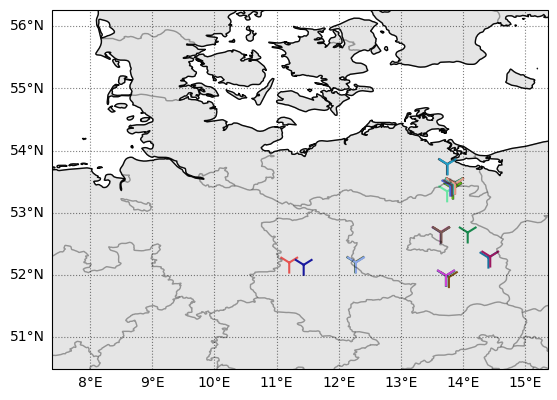

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="none", linewidth=1)

# get country borders
resolution = "10m"
category = "cultural"
name = "admin_1_states_provinces"
shpfilename = shapereader.natural_earth(resolution, category, name)
adm1_shapes = list(shapereader.Reader(shpfilename).geometries())


x, y = [x[0] for x in coordinates], [x[1] for x in coordinates]
ax.scatter(
    x,
    y,
    marker="1",
    s=250,
    c=[a6.plotting._colors.LABEL_COLORS[i] for i in range(len(coordinates))],
)

# Just plotted to avoid calling `ax.set_extent()`, which crashes the kernel
ax.scatter(
    [7.75, 15.0, 7.75, 15.0],  # longitudes
    [50.75, 50.75, 56.0, 56.0],  # latitudes
    alpha=0,
)

ax.add_geometries(
    adm1_shapes,
    ccrs.PlateCarree(),
    edgecolor="black",
    facecolor="gray",
    alpha=0.2,
)

ax.gridlines(
    crs=ccrs.PlateCarree(),
    color="black",
    alpha=0.5,
    linestyle=":",
    draw_labels=["left", "bottom"],
)

plt.savefig(plots / "turbine-positions.pdf")

## Summarize turbine properties in table

In [ ]:
def extract_turbine_data(path: pathlib.Path):
    d = xr.open_dataset(path)
    lat, lon = float(d["latitude"]), float(d["longitude"])
    altitude = float(d["level"])
    power_rating = float(d.attrs["power rating"].split(" ")[0]) * 1e-3
    hub_height = float(d.attrs["hub height"].split(" ")[0])
    start, end = (
        utils.times.numpy_datetime64_to_datetime(d["time"][0].values).strftime(
            "%Y-%m-%d"
        ),
        utils.times.numpy_datetime64_to_datetime(d["time"][-1].values).strftime(
            "%Y-%m-%d"
        ),
    )
    return [
        f"{lat:.1f}",
        f"{lon:.1f}",
        f"{altitude:.1f}",
        f"{hub_height:.0f}",
        f"{power_rating:.1f}",
        start,
        end,
    ]


data = [extract_turbine_data(path) for path in turbines_with_preprocessed_data]
df = pd.DataFrame(
    data=data,
    columns=[
        "Lat.",
        "Lon.",
        "Alt. [m]",
        "Hub height [m]",
        "Power rating [MW]",
        "Start date",
        "End date",
    ],
)
code = df.to_latex(
    float_format="%.2f",
    label="turbines",
    index=False,
    column_format="rrrrrcc",
    caption="""
    Properties of the wind turbines.
	Shown are the geographical position (latitude, longitude, altitude),
	hub height and power rating (or nominal power output),
	and start and end date of the available power production data
	of the respective turbine.
    """,
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/turbines-table.tex", "w"
) as f:
    f.write(code)

df

## Summarize errors for every LSWR

In [6]:
import dataclasses
import datetime


@dataclasses.dataclass
class ErrorsPerLswr:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)


def get_errors_per_lswr(data: xr.Dataset) -> dict[int, ErrorsPerLswr]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]

    errors_per_mode = {
        mode.label: ErrorsPerLswr(label=mode.label) for mode in modes
    }

    for i, turbine in enumerate(turbine_errors):
        print(f"{data.name}: {i}/{len(turbine_errors)}", end="\r")

        for mode, date in zip(modes, dates, strict=True):
            mode_power = errors_per_mode[mode.label]

            # Get time steps of production where LSWR appeared
            intersection = sorted(set(turbine.time.values) & set(date.values))

            if not intersection:
                logger.warning(
                    f"{data.name}: empty intersection for {i} and mode {mode.label}"
                )
                continue

            turbine_sub = turbine.sel(time=intersection, lswr_method="Default")

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            mode_power.nmae.extend(nmae.values.flatten().tolist())

            nrmse = turbine_sub["nrmse"]
            mode_power.nrmse.extend(nrmse.values.flatten().tolist())

    return errors_per_mode

errors_per_method = {
    lswr.name: get_errors_per_lswr(lswr) for lswr in lswrs if isinstance(lswr, xr.DataArray)
}

RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 31
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 32
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 0 and mode 37
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 1 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 1 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 1 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty int

RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 2 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 2 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 2 and mode 31
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 2 and mode 32
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 2 and mode 37
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 3 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 3 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 4 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 4 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 5 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:46 - 0:24:42 - GWL: empty intersection for 5 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:42 - GWL: empty intersection for 6 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 6 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 7 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 7 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 8 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 8 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 8 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 9 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 9 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 10 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 10 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 11 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 11 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 12 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 12 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 13 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:47 - 0:24:43 - GWL: empty intersection for 13 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 14 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 14 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 15 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 15 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 16 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 16 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 17 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 17 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 18 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 18 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 19 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 19 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 20 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 20 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 21 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 21 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 22 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:48 - 0:24:44 - GWL: empty intersection for 22 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 23 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 23 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 24 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 24 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 25 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 25 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 26 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 26 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 27 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 27 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 28 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 28 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 29 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 29 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 30 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 30 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 31 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:49 - 0:24:45 - GWL: empty intersection for 31 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:45 - GWL: empty intersection for 32 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 32 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 33 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 33 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 34 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 34 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 35 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 35 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 36 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 36 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 37 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 37 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 38 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 38 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 39 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-17 17:21:50 - 0:24:46 - GWL: empty intersection for 39 and mode 27


In [7]:
import pandas as pd


def errors_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"


latex_code = []
columns = {
    "$N$": lambda lswrs: [
        np.nansum(results.measurements) for results in lswrs.values()
    ],
    "NMAE [\%]": lambda lswrs: [
        errors_mean_with_std_as_string(results.nmae)
        for results in lswrs.values()
    ],
    "NRMSE [\%]": lambda lswrs: [
        errors_mean_with_std_as_string(results.nrmse)
        for results in lswrs.values()
    ],
}

reform = {
    (name, column): func(method)
    for name, method in errors_per_method.items()
    for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="errors-per-lswr-per-method",
    caption=f"Normalized MAE and RMSE of the Default model for the resulting LSWRs.",
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/errors-table.tex", "w"
) as f:
    f.write(code)


df

/tmp/ipykernel_16580/536788185.py:5: RuntimeWarning: Mean of empty slice
  return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"
/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


GWL                                       PCA                    \
       $N$         NMAE [\%]        NRMSE [\%]   $N$         NMAE [\%]   
1   2596.0  $10.00 \pm 4.94$  $12.57 \pm 5.95$   666   $9.89 \pm 4.60$   
2   1249.0   $9.89 \pm 5.45$  $12.40 \pm 6.52$   634  $10.13 \pm 5.71$   
3    243.0  $10.58 \pm 6.04$  $13.19 \pm 6.86$  1622   $9.37 \pm 4.71$   
4   1756.0   $9.61 \pm 5.25$  $12.11 \pm 6.28$  1049  $10.14 \pm 5.08$   
5   4044.0  $10.04 \pm 4.86$  $12.65 \pm 5.89$   799   $9.86 \pm 4.71$   
6   1871.0   $9.63 \pm 4.69$  $12.24 \pm 5.82$   913  $10.45 \pm 5.27$   
7    399.0  $10.01 \pm 4.93$  $12.48 \pm 5.81$  1936   $9.15 \pm 4.68$   
8     36.0  $11.08 \pm 5.43$  $13.84 \pm 6.60$  1062   $9.90 \pm 4.84$   
9   5218.0   $9.70 \pm 4.88$  $12.22 \pm 5.91$   649  $10.19 \pm 4.57$   
10  3105.0   $9.43 \pm 4.86$  $11.81 \pm 5.83$  1268  $10.41 \pm 5.46$   
11  1404.0   $9.59 \pm 5.24$  $12.13 \pm 6.36$   799  $10.24 \pm 5.10$   
12   933.0   $9.63 \pm 4.86$  $12.21 \pm 6.01$   827  $10.18 \pm 4.95$   
13   303.0  $10.38 \pm 5.31$  $12.87 \pm 6.44$  1215  $10.53 \pm 5.14$   
14  1508.0   $9.48 \pm 5.14$  $11.99 \pm 6.23$  1770   $9.69 \pm 5.32$   
15  3284.0   $9.94 \pm 4.87$  $12.48 \pm 5.88$   363   $9.58 \pm 4.85$   
16   580.0   $9.60 \pm 5.02$  $12.08 \pm 6.06$  1779   $9.41 \pm 4.93$   
17     0.0     $nan \pm nan$     $nan \pm nan$   863   $9.73 \pm 4.90$   
18    76.0   $8.17 \pm 3.57$  $10.81 \pm 4.67$  1014   $9.19 \pm 5.03$   
19  1817.0   $9.69 \pm 4.91$  $12.14 \pm 5.88$  2078   $9.57 \pm 4.82$   
20   977.0   $9.90 \pm 4.89$  $12.41 \pm 5.98$   465  $10.49 \pm 5.95$   
21   472.0  $10.05 \pm 5.16$  $12.53 \pm 6.18$  1209   $9.64 \pm 4.86$   
22    40.0   $9.62 \pm 4.79$  $12.19 \pm 5.94$  1287   $9.31 \pm 4.61$   
23   406.0  $10.36 \pm 5.22$  $12.98 \pm 6.30$  1701  $10.68 \pm 5.15$   
24   566.0  $10.39 \pm 5.47$  $12.86 \pm 6.52$   982  $10.14 \pm 5.24$   
25    53.0   $9.66 \pm 3.29$  $11.95 \pm 3.83$   391  $10.07 \pm 4.65$   
26   930.0   $9.39 \pm 5.33$  $11.91 \pm 6.33$   816   $8.91 \pm 4.75$   
27     0.0     $nan \pm nan$     $nan \pm nan$   439  $10.00 \pm 5.80$   
28   747.0  $10.07 \pm 4.68$  $12.79 \pm 5.71$  1457  $10.27 \pm 5.18$   
29  3779.0   $9.85 \pm 5.09$  $12.35 \pm 6.11$   787  $10.62 \pm 5.69$   
30   317.0   $9.90 \pm 4.83$  $12.31 \pm 5.87$   847   $9.86 \pm 4.74$   
31   500.0   $9.65 \pm 4.76$  $12.27 \pm 5.84$  1433   $9.26 \pm 4.49$   
32    37.0   $8.53 \pm 3.86$  $10.24 \pm 4.67$   895  $10.47 \pm 4.85$   
33   384.0   $9.96 \pm 5.01$  $12.41 \pm 6.11$   340   $9.26 \pm 4.67$   
34   649.0  $10.09 \pm 4.97$  $12.59 \pm 5.82$   630   $9.56 \pm 4.41$   
35   217.0   $9.21 \pm 4.25$  $11.62 \pm 5.29$  1100   $9.88 \pm 4.91$   
36  1239.0   $9.42 \pm 4.88$  $11.91 \pm 5.96$  1147   $9.93 \pm 4.94$   
37   109.0  $11.22 \pm 5.77$  $14.47 \pm 7.02$  2968   $9.05 \pm 4.57$   
38   742.0   $9.69 \pm 5.02$  $12.27 \pm 6.08$  2613   $8.86 \pm 4.43$   
39  2444.0   $9.64 \pm 4.65$  $12.11 \pm 5.64$  1586  $10.54 \pm 5.15$   
40   522.0   $9.98 \pm 4.79$  $12.50 \pm 5.83$  1153   $9.94 \pm 5.12$   

                      kPCA                                      DCv2  \
          NRMSE [\%]   $N$         NMAE [\%]        NRMSE [\%]   $N$   
1   $12.39 \pm 5.57$  1062   $9.81 \pm 4.77$  $12.32 \pm 5.84$  1096   
2   $12.52 \pm 6.71$   711  $10.14 \pm 5.14$  $12.70 \pm 6.14$  2282   
3   $11.90 \pm 5.82$  2190   $9.84 \pm 5.01$  $12.50 \pm 6.15$   470   
4   $12.52 \pm 5.85$   762   $9.55 \pm 4.58$  $11.88 \pm 5.49$  1423   
5   $12.44 \pm 5.75$   378   $9.42 \pm 3.84$  $11.60 \pm 4.77$  1747   
6   $12.93 \pm 6.27$   814   $9.99 \pm 4.87$  $12.48 \pm 5.76$   958   
7   $11.69 \pm 5.84$  1140   $9.34 \pm 4.82$  $11.81 \pm 5.87$  1397   
8   $12.41 \pm 5.88$   823  $10.40 \pm 4.91$  $12.80 \pm 5.70$   937   
9   $12.71 \pm 5.65$  2607   $8.71 \pm 4.49$  $11.20 \pm 5.68$  1114   
10  $13.04 \pm 6.45$  1284  $10.29 \pm 4.94$  $12.79 \pm 5.87$  1440   
11  $12.66 \pm 6.05$  1249  $10.54

/tmp/ipykernel_16580/660069518.py:28: RuntimeWarning: Mean of empty slice
  np.nanmean(getattr(error, metric)) * 100
/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_16580/660069518.py:28: RuntimeWarning: Mean of empty slice
  np.nanmean(getattr(error, metric)) * 100
/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
RANK 4 (LOCAL 4) - DEBUG - 2024-04-17 17:38:12 - 0:41:08 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK 4 (LOCAL 4) - DEBUG - 2024-04-17 17:38:12 - 0:41:08 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-17 17:38:12 - 0:41:08 - Writing TrueType font.


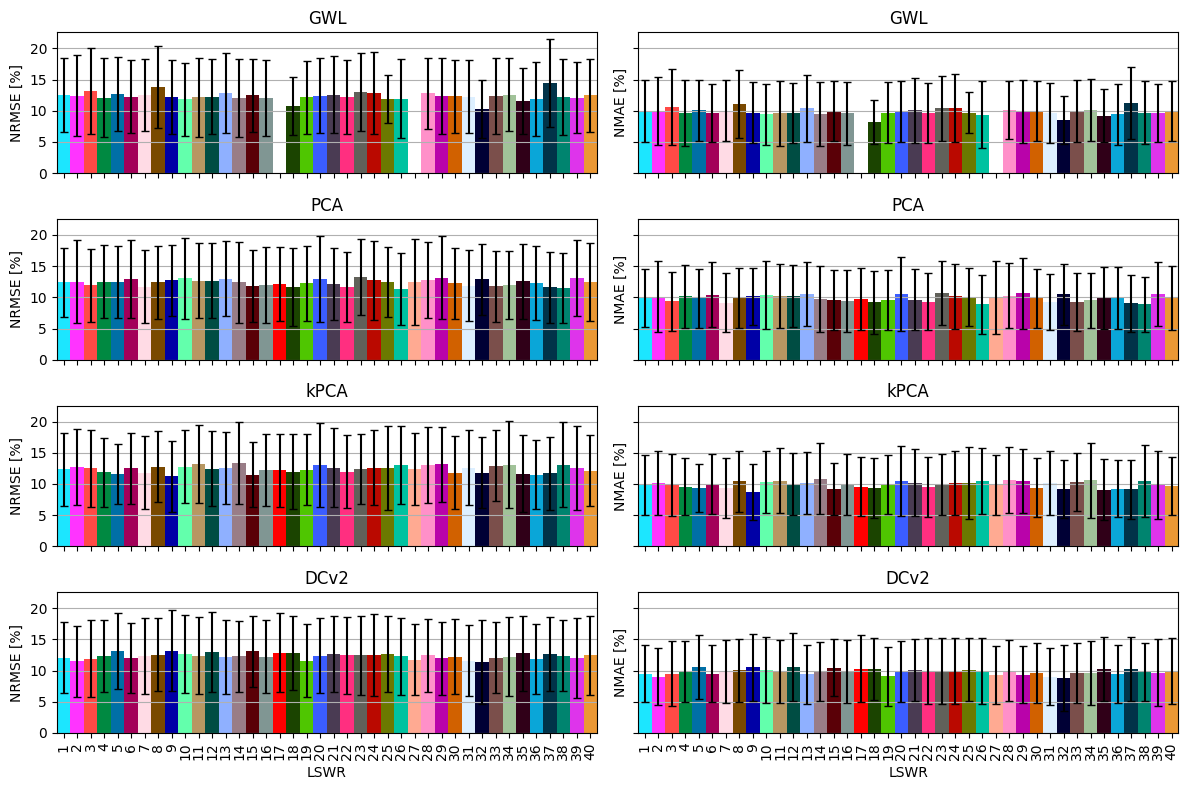

In [15]:
import matplotlib.pyplot as plt


def plot_errors_per_method(
    errors: dict[str, dict[int, ErrorsPerLswr]],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mean and std of NMAE and NRMSE for each LSWR and method."""
    n_rows = len(errors)
    n_cols = 2 # 1 column for NMAE and 1 for NRMSE
    labels = np.arange(1, n_lswr_categories + 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6 * n_cols, 2 * n_rows),
        nrows=n_rows,
        ncols=n_cols,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Errors per LSWRs")

    for i, (method, errors_per_lswr) in enumerate(errors.items()):
        for j, metric in enumerate(("nrmse", "nmae")):
            error_means = [
                np.nanmean(getattr(error, metric)) * 100
                for error in errors_per_lswr.values()
            ]
            error_stds = [
                np.nanstd(getattr(error, metric)) * 100
                for error in errors_per_lswr.values()
            ]
            ax = axs[i][j]
                
            ax.bar(
                labels,
                error_means,
                yerr=error_stds,
                width=1.0,  # removes gaps between the bars
                color=colors,
                align="center",
                alpha=1,
                ecolor="black",
                capsize=3,
            )

            ax.set_title(method)

            if i == n_rows - 1:
                ax.set_xlabel("LSWR")

            ax.set_ylabel(f"{metric.upper()} [%]")
            ax.set_xlim(*x_lims)
            ax.set_xticks(labels)
            ax.set_xticklabels(labels, rotation=90)
            ax.yaxis.grid(True)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-errors-comparison.pdf")


plot_errors_per_method(errors_per_method)

## Create timeseries plot with NRMSE for every LSWR method

In [ ]:
import pandas as pd
import dataclasses
import datetime

start, end = min(min(turbine.time.values) for turbine in turbine_errors), max(
    max(turbine.time.values) for turbine in turbine_errors
)
date_range = pd.date_range(start, end, freq="1d")
date_range


@dataclasses.dataclass
class ErrorsPerDay:
    time: pd.Timestamp
    measurements: int = 0
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)


def get_errors_per_day(
    data: xr.DataArray | None,
) -> dict[pd.Timestamp, ErrorsPerDay]:
    name = data.name if isinstance(data, xr.DataArray) else data
    errors_per_day = {step: ErrorsPerDay(time=step) for step in date_range}

    for i, step in enumerate(date_range):
        day_errors = errors_per_day[step]

        for j, turbine in enumerate(turbine_errors):
            print(
                f"{name}: day {i}/{len(date_range)}, turbine {j}/{len(turbine_errors)}",
                end="\r",
            )

            if step not in turbine["time"]:
                continue

            turbine_sub = turbine.sel(time=step, lswr_method=name)

            # Add to counter for turbines that contribute to the results
            day_errors.measurements += 1

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            day_errors.nmae.append(nmae.values.tolist())

            nrmse = turbine_sub["nrmse"]
            day_errors.nrmse.append(nrmse.values.tolist())

    return errors_per_day


errors_per_day = {
    (lswr.name if isinstance(lswr, xr.DataArray) else lswr): get_errors_per_day(lswr)
    for lswr in lswrs
}

In [ ]:
import matplotlib.pyplot as plt

n_rows = len(lswrs)

fig, axs = plt.subplots(
    figsize=(12, 4 * n_rows), nrows=n_rows, ncols=1, sharex=True
)

means_per_day = []
stds_per_day = []

attr = "nmae"

for results in errors_per_day.values():
    mean_per_day = (
        np.array([np.nanmean(getattr(day, attr)) for day in results.values()])
        * 100
    )
    std_per_day = (
        np.array([np.nanstd(getattr(day, attr)) for day in results.values()])
        * 100
    )

    means_per_day.append(mean_per_day)
    stds_per_day.append(std_per_day)

x_start, x_end = 100, 300

global_max = np.nanmax(
    [
        np.nanmax(m[x_start:x_end] + s[x_start:x_end])
        for m, s in zip(means_per_day, stds_per_day)
    ]
)
global_min = np.nanmin(
    [
        np.nanmin(m[x_start:x_end] - s[x_start:x_end])
        for m, s in zip(means_per_day, stds_per_day)
    ]
)

# If global minimum is lower than 2%, set it to 0.
# This is used for the ylim in each plot
if global_min < 2.0:
    global_min = 0.0

x = list(range(len(date_range)))

for i, (name, results) in enumerate(errors_per_day.items()):
    ax = axs[i]

    mean_per_day = means_per_day[i]
    std_per_day = stds_per_day[i]

    all_errs = (
        np.array(
            [nrmse for day in results.values() for nrmse in getattr(day, attr)]
        )
        * 100
    )
    global_mean = np.nanmean(all_errs)
    global_std = np.nanstd(all_errs)

    ax.plot(
        x,
        mean_per_day,
    )
    ax.fill_between(
        x,
        mean_per_day - std_per_day,
        mean_per_day + std_per_day,
        color="gray",
        alpha=0.5,
    )

    # Plot global mean and standard deviation
    ax.hlines(
        y=global_mean,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle="--",
        color="black",
        label=rf"$\mu_\mathrm{{{attr.upper()}}}^\mathrm{{global}} = ({global_mean:.2f} \pm {global_std:.2f})\,\%$",
    )

    ax.hlines(
        y=global_mean + global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )
    ax.hlines(
        y=global_mean - global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )

    ax.set_title(name)

    ax.set_xlim(x_start, x_end)

    if i == n_rows - 1:
        ax.set_xlabel("time")
        xticks = ax.get_xticks()
        xticklabels = [
            date_range[int(tick)].strftime("%Y-%m-%d") for tick in xticks[1:]
        ]
        ax.set_xticklabels(xticklabels, rotation=45)
    else:
        ax.set_xticklabels([])

    ax.set_ylabel(rf"$\mu_\mathrm{{{attr.upper()}}}$ [%]")

    ax.set_ylim(global_min * 0.9, global_max * 1.05)
    ax.legend()

fig.tight_layout()
plt.savefig(plots / f"forecast-error-timeseries-per-lswr-method-{attr}.pdf")